### Setting up the Notebook and importing libraries, data

In [1]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
%matplotlib inline

In [2]:
from glob import glob

In [3]:
#loads the data into a dictionary of dataframes
csv_files = glob("./zippedData/*.csv.gz")
csv_files_dict = {}
for filename in csv_files:
    filename_cleaned = os.path.basename(filename).replace(".csv", "").replace(".", "_") # cleaning the filenames
    filename_df = pd.read_csv(filename, index_col=0)
    csv_files_dict[filename_cleaned] = filename_df

In [4]:
# creates a second dictionary of data frames (identical to the above)
# this is the one to be manipulated, as csv_files_dict will be kept as the original version whenever needed


#*************
df_repository = {} 
for filename in csv_files:
    filename_cleaned = os.path.basename(filename).replace(".csv", "").replace(".", "_") # cleaning the filenames    
    exec("""df_repository[""" + """'""" + filename_cleaned + """']""" + """ = csv_files_dict['""" + filename_cleaned + """']""" )

### Custom Functions

In [5]:
# the function below cleans a data series that is populated by strings, 
# whose values actually refer to numbers


# takes a series as an argument and returns a new series of float values

def series_string_to_float(dataseries):
    # iterates through rows of the series
    
    float_list = []
    for string in dataseries:
        # It assumes that the series is populated by financial figures such as '$100,000'
        clean_string = string.replace('$', '') # removes '$' 
        clean_string = clean_string.replace(',', '') # removes ','
        float_list.append(  float(clean_string) )
    
    float_dict = {'new_column': float_list} 
    return pd.DataFrame(float_dict)

In [6]:
def clean_duplicates(dataframe): #returns a dataframe without duplicates
    cleaned_filter = dataframe.duplicated()
    index_to_drop = dataframe.loc[cleaned_filter].index
    return dataframe.drop(index=index_to_drop)

In [7]:
# function takes as arguments:
    # a series containing lists of professions 
    # a profession to screen for 
    # a second profession (optional)
    
# iterates through series and returns 1 when profession is found, 
# or 0 if not found

def is_prof(series, profession1, profession2=None):
    
    prof_list = []
    
    # iterates through series
    for lst in series:
        # tests for profession 
        if (profession1 in lst):
            prof_list.append(1)
        else: 
            # and tests for second profession (optional) 
            if (profession2) and (profession2 in lst):
                prof_list.append(1)
            else:
                prof_list.append(0)
    
    prof_dict = {('is_' + str(profession1)): prof_list}
    return pd.DataFrame(prof_dict)

### Data Cleaning and Exploration

In [8]:
# loop to parse the data frames df_repository 
# and returns them without duplicates

# uses the customs function  clean_duplicates()  

for db in df_repository.keys(): 
    df_repository[db] = clean_duplicates(df_repository[db])

In [9]:
# cleaning data from  **df_repository['tn_movie_budgets_gz']**

# cleans columns with numerical data, but stored as strings

for key in df_repository['tn_movie_budgets_gz'].loc[:,
            # columns to be cleaned                         
            ['production_budget', 'domestic_gross', 'worldwide_gross']].keys():
    
    df_repository['tn_movie_budgets_gz'][key] = series_string_to_float(
                                                df_repository['tn_movie_budgets_gz'][key])

    
# string to datetime format for the column release_date
df_repository['tn_movie_budgets_gz'].release_date = pd.to_datetime(df_repository['tn_movie_budgets_gz'].release_date)

In [10]:
# merging the DFs  **imdb_title_akas_gz**  and **tn_movie_budgets_gz** 


# merging on the movie name, so as to import the title_id 
# from the imdb tables to the new merged DF with financials
df_imdb_financials = pd.merge(df_repository['imdb_title_akas_gz'].reset_index(), 
                              df_repository['tn_movie_budgets_gz'], left_on='title',right_on='movie', how='inner')


df_imdb_financials.drop(columns=['ordering', 'movie', 'region', 'language', 'types',
       'attributes', 'is_original_title'], inplace=True)


#cleaning duplicates
df_imdb_financials = pd.DataFrame(clean_duplicates(df_imdb_financials))

In [11]:
df_imdb_financials.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3858 entries, 0 to 10131
Data columns (total 6 columns):
title_id             3858 non-null object
title                3858 non-null object
release_date         3858 non-null datetime64[ns]
production_budget    3858 non-null float64
domestic_gross       3858 non-null float64
worldwide_gross      3858 non-null float64
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 211.0+ KB


In [12]:
#  calculates the profits and add it as a feature to **df_imdb_financials**

df_imdb_financials['total_profit'] =  df_imdb_financials.worldwide_gross - df_imdb_financials.production_budget

df_imdb_financials.set_index('title_id', inplace=True)
    

In [13]:
# data cleaning for **imdb_name_basics_gz**

# splits the string values in primary_profession and known_for_titles into a list of strings

df_repository['imdb_name_basics_gz']['primary_profession'] = df_repository['imdb_name_basics_gz']['primary_profession'].str.split(',')
df_repository['imdb_name_basics_gz']['known_for_titles'] = df_repository['imdb_name_basics_gz']['known_for_titles'].str.split(',')


In [14]:
# data cleaning for **imdb_name_basics_gz**

# deletes rows with NaN either on known_for_titles column or on primary_profession

# selects index of rows to delete
filt1 = df_repository['imdb_name_basics_gz'].known_for_titles.isna()
filt2 = df_repository['imdb_name_basics_gz'].primary_profession.isna()

# merges them into a set
index_to_drop = set( list( df_repository['imdb_name_basics_gz'].loc[filt1].index ) 
                    + list( df_repository['imdb_name_basics_gz'].loc[filt2].index ))


df_repository['imdb_name_basics_gz'].drop(index=index_to_drop, inplace=True)

In [15]:
# adds features to **df_repository['imdb_name_basics_gz']** by using the custom function is_prof


# index reset to facilitate creation of features
df_repository['imdb_name_basics_gz'].reset_index(inplace=True) 


    # new columns that tell if the person is a:
    
        # an actor/actress
actor_col = is_prof(df_repository['imdb_name_basics_gz'].primary_profession, 
                           'actor', profession2='actress')

df_repository['imdb_name_basics_gz']['is_actor'] = actor_col.reset_index().is_actor


        # a producer 
prod_col = is_prof(df_repository['imdb_name_basics_gz'].primary_profession, 
                              'producer')

df_repository['imdb_name_basics_gz']['is_producer'] = prod_col.reset_index().is_producer

        # a director 
dir_col = is_prof(df_repository['imdb_name_basics_gz'].primary_profession, 
                              'director')

df_repository['imdb_name_basics_gz']['is_director'] = dir_col.reset_index().is_director

In [16]:
# cleans away rows of people who are neither a director, an actor nor a producer 

filt = (df_repository['imdb_name_basics_gz'].is_actor 
        + df_repository['imdb_name_basics_gz'].is_director 
        + df_repository['imdb_name_basics_gz'].is_producer) == 0

index_to_drop = df_repository['imdb_name_basics_gz'].loc[filt].index

df_repository['imdb_name_basics_gz'].drop(
    index=index_to_drop, inplace=True)

In [17]:
# creates two new columns to **df_repository['imdb_name_basics_gz']** :
    
#     avg_grossing: will contain the average grossing of movies
#                   the person is known for
    
#     total_grossing: will contain the sum of grossing of movies
#                   the person is known for 
    

# will contain values selected for new avg_grossing colum    
avg_grossing_column = [] 

# will contain values selected for new avg_grossing colum
total_grossing_column = [] 


for row in df_repository['imdb_name_basics_gz'].known_for_titles:
    
    # colects the numbers computed for each row 
    grossing_row = [] 
    
    for movie in row:
        
        # checks if the movie being parsed is contained in the df_imdb_financials, 
        # which is where we can fetch the grossing figures
        if movie in df_imdb_financials.index: 
            
            # if a movie has more then one version (different relase dates, for ex),  
            # the loop will return a data series (slice of df_imdb_financials) instead
            # of a single value
            if isinstance(df_imdb_financials.loc[movie], pd.DataFrame):
                
                # in that case, we select the last value
                grossing = df_imdb_financials.loc[movie].iloc[-1,-1]
            
            # otherwise the single value found is selected
            else:
                grossing = df_imdb_financials.worldwide_gross.loc[movie] 
                
            # appends the value found to 
            # grossing_row for further computation
            grossing_row.append(grossing)
            
    # if after parsing the row, something is found:
    if len(grossing_row) > 0:
        
        # the average is calculated and appended to avg_grossing
        avg_grossing = sum(grossing_row)/len(grossing_row)
        avg_grossing_column.append(avg_grossing)
        
         #the total is calculated and appended to total_grossing
        total_grossing_column.append(sum(grossing_row))
        
    # otherwiser 0 is appended so that the final series
    # is the correct length 
    else:
        avg_grossing_column.append(0)
        total_grossing_column.append(0)

# dictionary with computed values
dict_grossings = {'avg_grossing': avg_grossing_column, 'total_grossing': total_grossing_column}

# new DF with computed values
df_professionals_grossings = pd.DataFrame(dict_grossings)

In [18]:
# adds the new columns from the newly created ***df_professionals_grossings***  
# into  ***df_repository['imdb_name_basics_gz']***


# resets index in order to create the new columns that matche df_professionals_grossings
df_repository['imdb_name_basics_gz'].reset_index(inplace=True)
df_repository['imdb_name_basics_gz'].drop(columns='index', inplace=True)

#creates the new columns
df_repository['imdb_name_basics_gz']['avg_grossing'] = df_professionals_grossings.loc[:,'avg_grossing']
df_repository['imdb_name_basics_gz']['total_grossing'] = df_professionals_grossings.loc[:,'total_grossing']


# additional data cleaning - drops columns **birth_year**  and  **primary_profession** 
df_repository['imdb_name_basics_gz'].drop(columns=['birth_year','primary_profession'], inplace=True)

In [19]:
# additional cleaning - drops rows where **avg_grossing** is zero

filt = df_repository['imdb_name_basics_gz']["avg_grossing"] == 0
index_to_drop = df_repository['imdb_name_basics_gz'].loc[filt].index

df_repository['imdb_name_basics_gz'].drop(index=index_to_drop,inplace=True)

### Data Visualization

Plotting Directors, Actors and Producers most associated with high grossing movies

In [20]:
# Creates subsets of **imdb_name_basics_gz** 
# for Directors, Actors and Producers

filt = df_repository['imdb_name_basics_gz'].is_director == 1
df_directors = df_repository['imdb_name_basics_gz'].loc[filt]

filt1 = df_repository['imdb_name_basics_gz'].is_actor == 1
df_actors = df_repository['imdb_name_basics_gz'].loc[filt1]

filt2 = df_repository['imdb_name_basics_gz'].is_producer == 1
df_producers = df_repository['imdb_name_basics_gz'].loc[filt2]


In [24]:
# prepares the data to be plotted


#total number of movies
n_movies = len(df_imdb_financials)

#total number of directors
n_directors = len(df_directors)
n_actors = len(df_actors)
n_producers = len(df_producers)


# DF with the average movie grossings of the top 1% , top 10%, and the bottom 99% of movies
# from **df_imdb_financials**, which contains the financial data cross referenced with
# information from imdb

plotdata_imdb_financials = pd.DataFrame({
    
    'Top 1% vs Rest': [df_imdb_financials.worldwide_gross.nlargest(n=int(n_movies*0.01)).mean(),
                        df_imdb_financials.worldwide_gross.nlargest(n=int(n_movies*0.99)).mean()],
    
    'Top 1% vs Top 10%' : [df_imdb_financials.worldwide_gross.nlargest(n=int(n_movies*0.01)).mean(),
                        df_imdb_financials.worldwide_gross.nlargest(n=int(n_movies*0.1)).mean()]},
    index = [0, 1])


# DFs with the average movie grossings of the top 1% , top 10%, 
# and the bottom 99% of directors, actors and producers 
# from **imdb_name_basics_gz**, 
# which contains the main movies a person is known for

plotdata_directors = pd.DataFrame({
    
    'Top 1% vs Rest': [df_directors.avg_grossing.nlargest(n=int(n_directors*0.01)).mean(),
                  df_directors.avg_grossing.nlargest(n=int(n_directors*0.99)).mean()],
    
    'Top 1% vs Top 10%' : [df_directors.avg_grossing.nlargest(n=int(n_directors*0.01)).mean(),
                  df_directors.avg_grossing.nlargest(n=int(n_directors*0.1)).mean()]},
    
    index = [0, 1])


plotdata_actors = pd.DataFrame({
    
    'Top 1% vs Rest': [df_actors.avg_grossing.nlargest(n=int(n_actors*0.01)).mean(),
                  df_actors.avg_grossing.nlargest(n=int(n_actors*0.99)).mean()],
    
    'Top 1% vs Top 10%' : [df_actors.avg_grossing.nlargest(n=int(n_actors*0.01)).mean(),
                  df_actors.avg_grossing.nlargest(n=int(n_actors*0.1)).mean()]},
    index = [0, 1])
    
plotdata_producers = pd.DataFrame({
    
    'Top 1% vs Rest': [df_producers.avg_grossing.nlargest(n=int(n_producers*0.01)).mean(),
                  df_producers.avg_grossing.nlargest(n=int(n_producers*0.99)).mean()],
    
    'Top 1% vs Top 10%' : [df_producers.avg_grossing.nlargest(n=int(n_producers*0.01)).mean(),
                  df_producers.avg_grossing.nlargest(n=int(n_producers*0.1)).mean()]},
    
    index = [0, 1])

Text(0.5, 1.0, 'Top Grossing Producers \nTop 1% vs Top 10%')

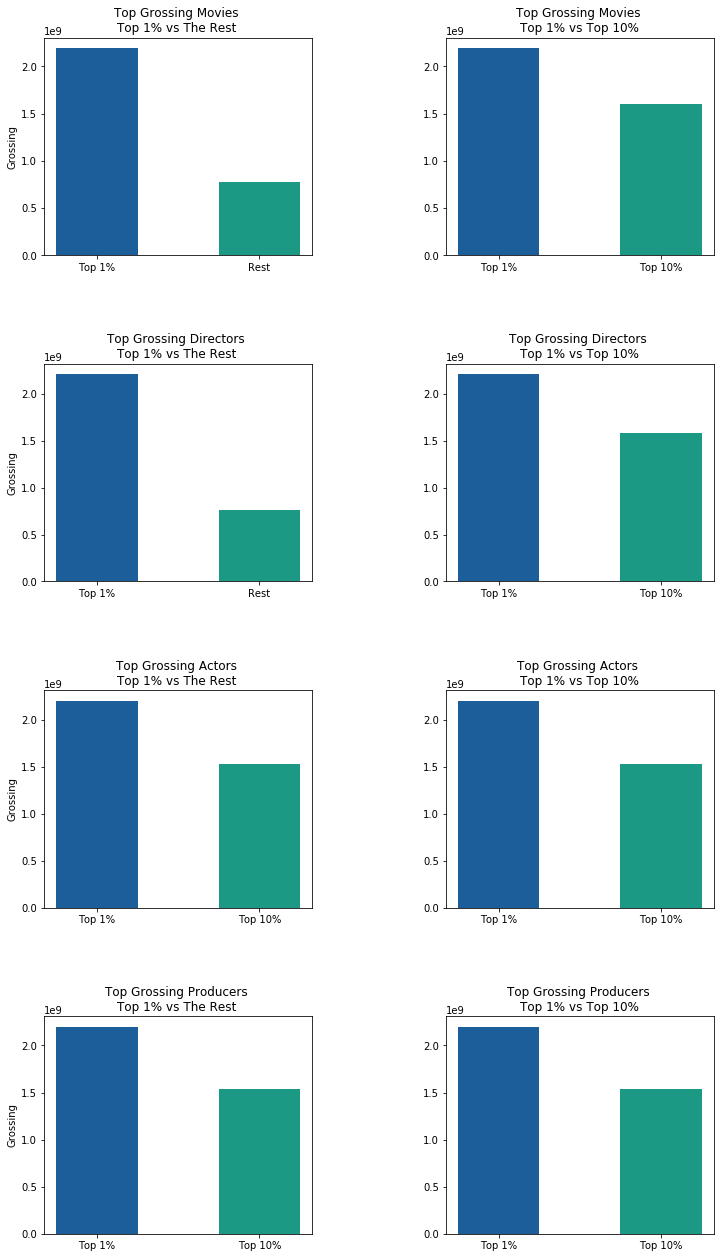

In [27]:
plt.figure(figsize=(12,22)).subplots_adjust( wspace=0.5, hspace=0.5)

Xr = ['Top 1%', 'Rest']
Xt = ['Top 1%', 'Top 10%']
Y = [10, 4]

ax1 = plt.subplot(421)
ax1.bar(Xr, plotdata_imdb_financials['Top 1% vs Rest'], width = 0.5, color=['#1C5E99', '#1C9985'], )

ax2 = plt.subplot(422)
ax2.bar(Xt, plotdata_imdb_financials['Top 1% vs Top 10%'], width = 0.5, color=['#1C5E99', '#1C9985'])

ax3 = plt.subplot(423)
ax3.bar(Xr, plotdata_directors['Top 1% vs Rest'], width = 0.5, color=['#1C5E99', '#1C9985'])

ax4 = plt.subplot(424)
ax4.bar(Xt, plotdata_directors['Top 1% vs Top 10%'], width = 0.5, color=['#1C5E99', '#1C9985'])

ax5 = plt.subplot(425)
ax5.bar(Xt, plotdata_actors['Top 1% vs Top 10%'], width = 0.5, color=['#1C5E99', '#1C9985'])

ax6 = plt.subplot(426)
ax6.bar(Xt, plotdata_actors['Top 1% vs Top 10%'], width = 0.5, color=['#1C5E99', '#1C9985'])

ax7 = plt.subplot(427)
ax7.bar(Xt, plotdata_producers['Top 1% vs Top 10%'], width = 0.5, color=['#1C5E99', '#1C9985'])

ax8 = plt.subplot(428)
ax8.bar(Xt, plotdata_producers['Top 1% vs Top 10%'], width = 0.5, color=['#1C5E99', '#1C9985'])

ax1.set_title("""Top Grossing Movies 
Top 1% vs The Rest """)
ax1.set_ylabel("Grossing")

ax2.set_title("""Top Grossing Movies 
Top 1% vs Top 10%""")


ax3.set_title("""Top Grossing Directors 
Top 1% vs The Rest """)
ax3.set_ylabel("Grossing")

ax4.set_title("""Top Grossing Directors 
Top 1% vs Top 10%""")

ax5.set_title("""Top Grossing Actors 
Top 1% vs The Rest """)
ax5.set_ylabel("Grossing")

ax6.set_title("""Top Grossing Actors 
Top 1% vs Top 10%""")

ax7.set_title("""Top Grossing Producers 
Top 1% vs The Rest """)
ax7.set_ylabel("Grossing")

ax8.set_title("""Top Grossing Producers 
Top 1% vs Top 10%""")